# Object detection: Added brightness

In [1]:
import re
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from dpemu import runner
from dpemu.dataset_utils import load_coco_val_2017
from dpemu.filters.image import Brightness
from dpemu.ml_utils import run_ml_module_using_cli, load_yolov3
from dpemu.nodes import Array, Series
from dpemu.plotting_utils import print_results_by_model, visualize_scores
from dpemu.utils import get_project_root

In [2]:
def get_err_root_node():
    err_node = Array()
    err_root_node = Series(err_node)
    err_node.addfilter(Brightness("tar", "rat", "range"))
    return err_root_node

In [3]:
def get_err_params_list():
    rat_steps = np.linspace(0, 1.4, num=8)
    return [{"tar": 1, "rat": rat, "range": 255} for rat in rat_steps]

In [4]:
class Preprocessor:

    def run(self, _, imgs, params):
        img_filenames = params["img_filenames"]

        for i, img_arr in enumerate(imgs):
            img = Image.fromarray(img_arr)
            path_to_img = f"{get_project_root()}/tmp/val2017/" + img_filenames[i]
            img.save(path_to_img, "jpeg", quality=100)

        return None, imgs, {}

In [5]:
class YOLOv3Model:

    def run(self, _, imgs, params):
        path_to_yolov3_weights, path_to_yolov3_cfg = load_yolov3()

        cline = f"{get_project_root()}/libs/darknet/darknet detector map {get_project_root()}/data/coco.data \
            {path_to_yolov3_cfg} {path_to_yolov3_weights}"
        out = run_ml_module_using_cli(cline, show_stdout=False)

        match = re.search(r"\(mAP@0.50\) = (\d+\.\d+)", out)
        return {"mAP-50": round(float(match.group(1)), 3)}


class AbstractDetectronModel(ABC):

    def run(self, _, imgs, params):
        path_to_cfg = self.get_path_to_cfg()
        url_to_weights = self.get_url_to_weights()

        cline = f"""{get_project_root()}/libs/Detectron/tools/test_net.py \
            --cfg {path_to_cfg} \
            TEST.WEIGHTS {url_to_weights} \
            NUM_GPUS 1 \
            TEST.DATASETS '("coco_2017_val",)' \
            MODEL.MASK_ON False \
            OUTPUT_DIR {get_project_root()}/tmp \
            DOWNLOAD_CACHE {get_project_root()}/tmp"""
        out = run_ml_module_using_cli(cline, show_stdout=False)

        match = re.search(r"IoU=0.50      \| area=   all \| maxDets=100 ] = (\d+\.\d+)", out)
        return {"mAP-50": round(float(match.group(1)), 3)}

    @abstractmethod
    def get_path_to_cfg(self):
        pass

    @abstractmethod
    def get_url_to_weights(self):
        pass


class FasterRCNNModel(AbstractDetectronModel):

    def get_path_to_cfg(self):
        return f"{get_project_root()}/libs/Detectron/configs/12_2017_baselines/e2e_faster_rcnn_X-101-64x4d-FPN_1x.yaml"

    def get_url_to_weights(self):
        return (
            "https://dl.fbaipublicfiles.com/detectron/35858015/12_2017_baselines/"
            "e2e_faster_rcnn_X-101-64x4d-FPN_1x.yaml.01_40_54.1xc565DE/output/train/"
            "coco_2014_train%3Acoco_2014_valminusminival/generalized_rcnn/model_final.pkl"
        )


class MaskRCNNModel(AbstractDetectronModel):

    def get_path_to_cfg(self):
        return f"{get_project_root()}/libs/Detectron/configs/12_2017_baselines/e2e_mask_rcnn_X-101-64x4d-FPN_1x.yaml"

    def get_url_to_weights(self):
        return (
            "https://dl.fbaipublicfiles.com/detectron/36494496/12_2017_baselines/"
            "e2e_mask_rcnn_X-101-64x4d-FPN_1x.yaml.07_50_11.fkwVtEvg/output/train/"
            "coco_2014_train%3Acoco_2014_valminusminival/generalized_rcnn/model_final.pkl"
        )


class RetinaNetModel(AbstractDetectronModel):

    def get_path_to_cfg(self):
        return f"{get_project_root()}/libs/Detectron/configs/12_2017_baselines/retinanet_X-101-64x4d-FPN_1x.yaml"

    def get_url_to_weights(self):
        return (
            "https://dl.fbaipublicfiles.com/detectron/36768875/12_2017_baselines/"
            "retinanet_X-101-64x4d-FPN_1x.yaml.08_34_37.FSXgMpzP/output/train/"
            "coco_2014_train%3Acoco_2014_valminusminival/retinanet/model_final.pkl"
        )

In [6]:
def get_model_params_dict_list():
    return [
        {"model": FasterRCNNModel, "params_list": [{}]},
        {"model": MaskRCNNModel, "params_list": [{}]},
        {"model": RetinaNetModel, "params_list": [{}]},
        {"model": YOLOv3Model, "params_list": [{}]},
    ]

In [7]:
def visualize(df):
    visualize_scores(
        df, 
        score_names=["mAP-50"], 
        is_higher_score_better=[True], 
        err_param_name="rat", 
        title="Object detection with added brightness"
    )
    plt.show()

In [8]:
def main():
    imgs, _, _, img_filenames = load_coco_val_2017()

    df = runner.run(
        train_data=None,
        test_data=imgs,
        preproc=Preprocessor,
        preproc_params={"img_filenames": img_filenames},
        err_root_node=get_err_root_node(),
        err_params_list=get_err_params_list(),
        model_params_dict_list=get_model_params_dict_list(),
        n_processes=1
    )

    print_results_by_model(df, dropped_columns=["tar", "range"])
    visualize(df)

loading annotations into memory...
Done (t=0.51s)
creating index...
index created!


  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [47:55<5:35:27, 2875.41s/it]

 25%|██▌       | 2/8 [1:35:32<4:46:59, 2869.98s/it]

 38%|███▊      | 3/8 [2:22:59<3:58:35, 2863.07s/it]

 50%|█████     | 4/8 [3:10:11<3:10:15, 2853.80s/it]

 62%|██████▎   | 5/8 [3:57:10<2:22:10, 2843.37s/it]

 75%|███████▌  | 6/8 [4:43:53<1:34:22, 2831.07s/it]

 88%|████████▊ | 7/8 [5:30:14<46:56, 2816.10s/it]  

100%|██████████| 8/8 [6:16:10<00:00, 2798.09s/it]


FasterRCNN #1


,mAP-50,rat,time_err,time_pre,time_mod
0,0.637,0.0,25.482,191.538,782.473
1,0.568,0.2,24.634,193.666,773.755
2,0.522,0.4,24.803,190.588,771.368
3,0.495,0.6,25.511,183.167,768.999
4,0.453,0.8,24.606,178.801,767.146
5,0.395,1.0,25.253,170.736,762.966
6,0.317,1.2,24.191,163.135,760.870
7,0.224,1.4,24.586,153.263,758.272


MaskRCNN #1


,mAP-50,rat,time_err,time_pre,time_mod
0,0.643,0.0,25.482,191.538,773.686
1,0.575,0.2,24.634,193.666,771.586
2,0.526,0.4,24.803,190.588,768.721
3,0.503,0.6,25.511,183.167,767.139
4,0.466,0.8,24.606,178.801,763.531
5,0.411,1.0,25.253,170.736,761.261
6,0.333,1.2,24.191,163.135,758.198
7,0.244,1.4,24.586,153.263,754.346


RetinaNet #1


,mAP-50,rat,time_err,time_pre,time_mod
0,0.594,0.0,25.482,191.538,1007.041
1,0.529,0.2,24.634,193.666,1006.339
2,0.488,0.4,24.803,190.588,1003.530
3,0.464,0.6,25.511,183.167,999.181
4,0.429,0.8,24.606,178.801,998.645
5,0.378,1.0,25.253,170.736,995.535
6,0.311,1.2,24.191,163.135,988.472
7,0.228,1.4,24.586,153.263,980.072


YOLOv3 #1


,mAP-50,rat,time_err,time_pre,time_mod
0,0.555,0.0,25.482,191.538,91.312
1,0.512,0.2,24.634,193.666,82.249
2,0.471,0.4,24.803,190.588,81.664
3,0.450,0.6,25.511,183.167,81.264
4,0.420,0.8,24.606,178.801,81.255
5,0.381,1.0,25.253,170.736,81.076
6,0.321,1.2,24.191,163.135,80.890
7,0.255,1.4,24.586,153.263,79.988


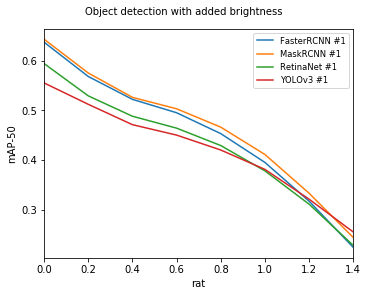

In [9]:
main()

The notebook for this case study can be found [here](https://github.com/dpEmu/dpEmu/blob/master/docs/case_studies/Object_Detection_Added_Brightness.ipynb).